<div style="float: right; color: red;">Please, rename this file to <code style="color:red">HW6.ipynb</code> and save it in <code style="color:red">MSA8010F16/HW6</code>
</div>

# Homework 6: Preprocessing Data
We use a data set from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing 
to experiment with a Decision Tree classifier http://www.saedsayad.com/decision_tree.htm

Scikit-Learn: http://scikit-learn.org/stable/modules/tree.html#tree

Book slides:
- http://131.96.197.204/~pmolnar/mlbook/BookSlides_4A_Information-based_Learning.pdf
- http://131.96.197.204/~pmolnar/mlbook/BookSlides_4B_Information-based_Learning.pdf



### Bank Marketing Data Set 
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

There are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs). 
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs). 
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM). 

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


Attribute Information:

Input variables:
- *bank client data:*
        1 age (numeric)
        2 job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
        3 marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
        4 education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
        5 default: has credit in default? (categorical: 'no','yes','unknown')
        6 housing: has housing loan? (categorical: 'no','yes','unknown')
        7 loan: has personal loan? (categorical: 'no','yes','unknown')
- *related with the last contact of the current campaign:*
        8 contact: contact communication type (categorical: 'cellular','telephone') 
        9 month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
        10 day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
        11 duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- *other attributes:*
        12 campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        13 pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
        14 previous: number of contacts performed before this campaign and for this client (numeric)
        15 poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- *social and economic context attributes*
        16 emp.var.rate: employment variation rate - quarterly indicator (numeric)
        17 cons.price.idx: consumer price index - monthly indicator (numeric) 
        18 cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
        19 euribor3m: euribor 3 month rate - daily indicator (numeric)
        20 nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
    21 y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATAFILE = '/home/data/archive.ics.uci.edu/BankMarketing/bank.csv'
###DATAFILE = 'data/bank.csv'  ### using locally

In [22]:
df = pd.read_csv(DATAFILE, sep=';')
df
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [ ]:
catcols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'poutcome']

## Step 1: Investigate Data Set
- We have a number of categorical data: What's their cardinality? How are the levels distributed?
- What's the distribution on numeric values? Do we see any correlations?

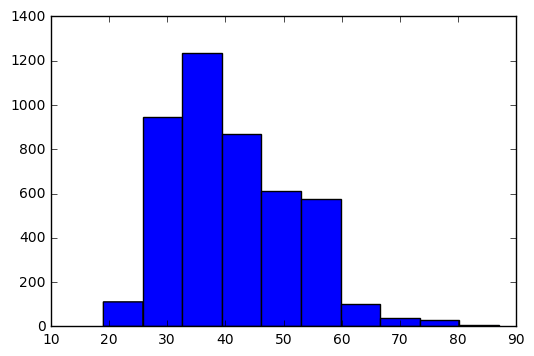

In [16]:
%matplotlib inline
fig = plt.figure()
hst = plt.hist(df.age)

In [4]:
df.groupby('contact').count()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
contact,,,,,,,,,,,,,,,,
cellular,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896,2896
telephone,301,301,301,301,301,301,301,301,301,301,301,301,301,301,301,301
unknown,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324,1324


## Step 2: Prepare for ML algorithm
The ML algorithms in Scikit-Learn use Matrices (with numeric values). We need to convert our data-frame into a feature matrix `X` and a target vector `y`.

In [10]:
?pd.DataFrame.as_matrix

In [ ]:
catcols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for c in catcols:
    c_dict = {}
    c_levels = df[c].unique()
    for i in range(len(c_levels)):
        c_dict[c_levels[i]] = i
    df[c].replace(c_dict, inplace=True)

In [29]:
features = ['age', 'marital', 'education', 'housing', 'duration' ]
X = df[features].as_matrix()
X

array([[ 30,   0,   0,   0,  79],
       [ 33,   0,   1,   1, 220],
       [ 35,   1,   2,   1, 185],
       ..., 
       [ 57,   0,   1,   0, 151],
       [ 28,   0,   1,   0, 129],
       [ 44,   1,   2,   1, 345]])

In [34]:
y = df.y.replace({'no':0, 'yes':1}).as_matrix()

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [38]:
X_train, X_test, y_train, y_test

(array([[ 48,   0,   0,   0, 348],
        [ 32,   0,   1,   1, 171],
        [ 26,   1,   1,   1,  95],
        ..., 
        [ 46,   0,   2,   1, 105],
        [ 47,   1,   2,   0,  71],
        [ 58,   0,   0,   0, 156]]), array([[ 51,   0,   1,   0, 123],
        [ 50,   0,   2,   0, 510],
        [ 50,   0,   1,   0, 131],
        ..., 
        [ 36,   1,   0,   0, 217],
        [ 57,   0,   1,   1,  73],
        [ 52,   0,   1,   0,  82]]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [9]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

## Step 3: Training
1. split data into **training** and **test** sets
2. fit the model

In [8]:
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import train_test_split

In [39]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)

In [40]:
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [41]:
score

0.89220563847429524

## Step 4: Evaluate Model
1. predict $\hat y$ for your model on **test set**
2. calculate confusion matrix and derive measures
3. visualize if suitable

In [43]:
ŷ = clf.predict(X_test)

In [56]:
TP = ((y_test+ŷ)== 2).sum()
TN = ((y_test+ŷ)== 0).sum()
FP = ((y_test-ŷ)== -1).sum()
FN = ((y_test-ŷ)== 1).sum()
[[TP, FN], [FP, TN]] 
##np.abs(y_test-ŷ).sum()

[[51, 138], [57, 1563]]

## Step 5: Figure out how to improve and go back to Step 2 or 3
This is an experiemnt. What can we change to improve the performance of the model?
- Include or exclude certain features
- Scale or transform values of feature vectors
- Identify outliers (noise) and remove them
- Adjust parameters of the ML algorithm 